In [1]:
import os, sys

import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import scipy.linalg as sla
import pandas as pd
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry.polygon import LinearRing

from astropy.io import fits
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

In [2]:
def ellipse_polyline(ellipses, n=10000):
    t = np.linspace(0, 2*np.pi, n, endpoint=False)
    st = np.sin(t)
    ct = np.cos(t)
    result = []
    for x0, y0, a, b, angle in ellipses:
        angle = np.deg2rad(angle)
        sa = np.sin(angle)
        ca = np.cos(angle)
        p = np.empty((n, 2))
        p[:, 0] = x0 + a * ca * ct - b * sa * st
        p[:, 1] = y0 + a * sa * ct + b * ca * st
        result.append(p)
    return result

## return True if circumference of two ellipses intersect
def ell_itersect(Ell_A, Ell_B):
    
    ell_a = (Ell_A[0][0], Ell_A[0][1], Ell_A[1], Ell_A[2], Ell_A[3])
    ell_b = (Ell_B[0][0], Ell_B[0][1], Ell_B[1], Ell_B[2], Ell_B[3])
    
    if not np.isnan(np.sum(ell_a)) and not np.isnan(np.sum(ell_b)):
    
        ellipses = [ell_a, ell_b]
        a, b = ellipse_polyline(ellipses)
        ea = LinearRing(a)
        eb = LinearRing(b)
        try:
            mp = ea.intersection(eb)
            return (mp.type=="MultiPoint")
        except:
            print((ell_a, ell_b))
            return True   # likely invalid
    else:
        return False

In [3]:
## returns True if the surface of two ellipoids cross each other
def ellipsoid_intersection_test(Ell_A, Ell_B, tau=1):
    
    Sigma_A, mu_A = Ell_A[4], Ell_A[0]
    Sigma_B, mu_B = Ell_B[4], Ell_B[0]
    
    lambdas, Phi, v_squared = ellipsoid_intersection_test_helper(Sigma_A, Sigma_B, mu_A, mu_B)
    res = minimize_scalar(ellipsoid_K_function,
                          bracket=[0.0, 0.5, 1.0],
                          args=(lambdas, v_squared, tau))
    return (res.fun[0] >= 0)


def ellipsoid_intersection_test_helper(Sigma_A, Sigma_B, mu_A, mu_B):
    lambdas, Phi = eigh(Sigma_A, b=Sigma_B)
    v_squared = np.dot(Phi.T, mu_A - mu_B) ** 2
    return lambdas, Phi, v_squared


def ellipsoid_K_function(ss, lambdas, v_squared, tau):
    ss = np.array(ss).reshape((-1,1))
    lambdas = np.array(lambdas).reshape((1,-1))
    v_squared = np.array(v_squared).reshape((1,-1))
    return 1.-(1./tau**2)*np.sum(v_squared*((ss*(1.-ss))/(1.+ss*(lambdas-1.))), axis=1)

In [4]:
## This function allows to execute the OS commands
def xcmd(cmd, verbose=True):
    """Runs an OS command
    :param cmd: terminal command
    :type cmd: ``str``
    :param verbose: printing the details, default True 
    :type verbose: ``boolean``
    :return: OS outputs
    :rtype: ``str``
    """

    if verbose: print('\n'+cmd)

    tmp=os.popen(cmd)
    output=''
    for x in tmp: output+=x
    if 'abort' in output:
        failure=True
    else:
        failure=tmp.close()
    if False:
        print('execution of %s failed' % cmd)
        print('error is as follows', output)
        sys.exit()
    else:
        return output

##########################################################################

In [5]:
def createDir(folderPath):
    """generating a directory/folder if it doesn't exist
    :param folderPath: path to the desired folder
    :type folderPath: ``str``
    :return: True is created, False if the folder already exists
    :rtype: ``str``
    """

    if not os.path.exists(folderPath):
        os.makedirs(folderPath)
        return True
    else:
        False

In [6]:
def unit_vecort(angle):
    
    theta = angle * np.pi / 180.
    ux = np.cos(theta)
    uy = np.sin(theta)
    
    return (ux, uy)

def get_Sigma(Smajor, Sminor, angle):

    u1 = unit_vecort(angle)
    u2 = unit_vecort(angle-90)
    R = np.vstack((u1,u2))
    L = R.T
    X = np.diag((1./Smajor**2, 1./Sminor**2))
    A = np.matmul(np.matmul(L, X), R)

    return np.linalg.inv(A)

In [7]:
def make_Ellipse(center, Smajor, Sminor, angle):
    
    Sigma = get_Sigma(Smajor, Sminor, angle)
    return [np.asarray(center), Smajor, Sminor, angle, Sigma]

def plot_Ellipse(Ell, ax=None, **kwargs):
    
    if ax is None:
        ax = plt.gca()
    
    e = patches.Ellipse(Ell[0], width=2*Ell[1], height=2*Ell[2], angle=Ell[3], **kwargs)
    ax.add_patch(e)
    
    return ax

In [8]:
def list_Ell(data_frame):
    
    Ell_list = []
    
    for i in range(len(data_frame)):
        
        df = data_frame.iloc[i]
        Smajor = df.Rmaj
        Sminor = Smajor*(1.-df.ellip)
        angle = df.alpha+90
        center = (df.x0, df.y0)
        Sigma = get_Sigma(Smajor, Sminor, angle)
        Ell = make_Ellipse(center, Smajor, Sminor, angle)
        
        Ell_list.append(Ell)
    
    return Ell_list

In [9]:
# df is a Pandas series that holds one ellipse
def plot_E(df, ax=None, **kwargs):
    
    Smajor = df.Rmaj
    Sminor = Smajor*(1.-df.ellip)
    
    angle = df.alpha+90
    center = (df.x0, df.y0)
    Sigma = get_Sigma(Smajor, Sminor, angle)
    Ell = make_Ellipse(center, Smajor, Sminor, angle)

    if ax is None:
        ax = plt.gca()
        
    plot_Ellipse(Ell, ax=ax, **kwargs)
    
    return ax

In [10]:
#https://math.stackexchange.com/questions/1114879/detect-if-two-ellipses-intersect

In [11]:
def tv(fits_file, ax=None, options=""):

    jpg_name = 'tv.jpg'

    ## Monsta script
    script = """
    rd 1 '"""+fits_file+"""'
    tv 1 """+options+""" JPEG="""+jpg_name+"""
    q

    """

    run_monsta(script, 'tv.pro', 'tv.log')
    
    xcmd("rm tv.pro & rm tv.log &", verbose=False)
    
    
    img = mpimg.imread(jpg_name)
    x_max, y_max, _ = img.shape
        
    if ax is None:
        plt.figure(figsize=(10,10))
        plt.subplot(111)
        ax = plt.gca()

    ax.set_xlim([0, x_max])
    ax.set_ylim([0, y_max])

    imgplot = ax.imshow(np.flipud(img))

    return ax

In [12]:
def run_monsta(script, Monsta_pro, Monsta_log, monsta="/home/ehsan/Home/Monsta/bin/monsta"):
    
    with open(Monsta_pro, 'w') as f:
        f.write(script)

    cmd = monsta+' '+Monsta_pro
    xcmd(cmd + ' > '+Monsta_log, verbose=False)

    with open(Monsta_log) as f:
        text = f.read()
        if "ERROR" in text.upper().split( ):
            print(text)
            return Monsta_log
            

In [13]:
def imOpen(inFits):
    
    hdu_list = fits.open(inFits)
    imarray = hdu_list[0].data
    header = hdu_list[0].header   
    
    return imarray, header
    

In [14]:
def seg2mask(inFits, outMask, overwrite=True):
    
    imarray, header = imOpen(inFits)
    imarray[imarray==0] = -1
    imarray[imarray>0] = 0
    imarray[imarray==-1] = 1
    
    fits.writeto(outMask, imarray, header, overwrite=overwrite)
    
    return imarray

In [15]:
class ellOBJ:
    
    x0 = 0
    y0 = 0
    a  = 1
    b  = 1
    name = ""
    R = 1        # Kron Radius
    angle = 0    # Position angle (CCW/x)
    
    catalName = "catal.dat"
    objRoot = './'
    monsta='/home/ehsan/Home/Monsta/bin/monsta'
    
    def __init__(self, name, outFolder=None):
        
        if outFolder is not None:
            createDir(outFolder)
            self.objRoot = outFolder+'/'
        
        self.name = name
        self.SExtract()
        
        hdu_list = fits.open('{}/{}j.fits'.format(name,name))
        image_data = hdu_list[0].data
        w = wcs.WCS(hdu_list[0].header)
        self.x_max, self.y_max = image_data.shape
        
        
        im, mask2 = self.backSextract()
        masked_image = im*mask2
        a = masked_image
        a = a[(a!=0)]
        self.sky_med = np.median(a)
        self.sky_ave = np.mean(a)
        self.sky_std = np.std(a)
        
    def tv_resid(self, model=0, ax=None, options="", additions=""):
        root = self.objRoot
        suffix = '.%03d'%model
        fits_file = root+'/resid'+suffix
        return self.tv(fits_file=fits_file, ax=ax, options=options, additions=additions)

    def tv_model(self, model=0, ax=None, options="", additions=""):
        root = self.objRoot
        suffix = '.%03d'%model
        fits_file = root+'/model'+suffix
        return self.tv(fits_file=fits_file, ax=ax, options=options, additions=additions)
    
    
    def tv(self, fits_file=None, ax=None, options="", additions=""):
        
        if fits_file is None:
            name = self.name
            fits_file = "{}/{}j.fits".format(name, name)
        
        root = self.objRoot
        jpg_name = root+'tv.jpg'
        
        ## Monsta script
        script = """
        rd 1 '"""+fits_file+"""'
        """+additions+"""
        tv 1 """+options+""" JPEG="""+jpg_name+"""
        q
        
        """
        
        self.run_monsta(script, root+'tv.pro', root+'tv.log')
        
        return self.plot_jpg(jpg_name, ax=ax)
        
        
        
    
    def SExtract(self):
        
        name = self.name
        root = self.objRoot
        
        catalName = root + self.catalName
        segmentation = root + 'segmentation.fits'
        
        cmd = 'sex -c wfc3j_sex.config {}/{}j.fits'.format(name,name)+' -CHECKIMAGE_TYPE SEGMENTATION -CHECKIMAGE_NAME '+segmentation+' -CATALOG_NAME ' + catalName
        
        #print(cmd)
        
        xcmd(cmd + ' > '+root+'sextractor.log', verbose=False)
        
        
        col_names = self.getColName(catalName)

        df = pd.read_csv(catalName, delimiter=r"\s+", skiprows=len(col_names), 
                         header = None, names = col_names[:18], usecols = range(18))
        
        self.x0 = df.loc[0].X_IMAGE
        self.y0 = df.loc[0].Y_IMAGE
        A  = df.loc[0].A_IMAGE
        B  = df.loc[0].B_IMAGE
        R  = df.loc[0].KRON_RADIUS
        self.angle  = df.loc[0].THETA_IMAGE
        self.a = A*R
        self.b = B*R
        self.R = R
        self.name = name
        
    
    def elliprof(self, inner_r=5, outer_r=200, sky=None, 
                 cosnx="", k=None, 
                 nr=40, niter=10,
                 model = 0, mask=None, options=""
                ):
        
        root = self.objRoot
        suffix = '.%03d'%model
        
        if sky is None:
            sky = self.sky_med
        
        if mask is None:
            maskName = './common.mask'
        else:
            maskName = root+'/mask'+'.%03d'%mask
               
        if cosnx == "":
            kosnx = ""
        else:
            if k is None:
                kosnx = cosnx+"=0"
            else:
                kosnx = cosnx+"="+str(k)
        
        
        residName = root+'/resid'+suffix
        modelName = root+'/model'+suffix
        ellipseFile = root+'/elliprof'+suffix
        objName = root+'/'+self.name+suffix
                                                                    
        elliprof_cmd = "elliprof 3  model rmstar x0="+str(self.x0)+" y0="+str(self.y0)
        elliprof_cmd += " r0="+str(inner_r)+" r1="+str(outer_r)+" nr="+str(nr)+" niter="+str(niter)+" "+kosnx
        elliprof_cmd += " "+options
        
        ## Monsta script
        script = """
        string name '"""+self.name+"""'
        rd 1 '{name}/{name}j.fits'
        sc 1 """+str(sky)+"""                            ! sky subtraction
        rd 2 """+maskName+"""
        mi 1 2
        tv 1 sqrt JPEG="""+objName+""".jpg
        cop 3 1 
        """+elliprof_cmd+"""
        print elliprof file="""+ellipseFile+"""
        cop 4 1
        si 4 3
        ac 3 """+str(sky)+"""
        mi 3 2
        mi 4 2
        wd 3 """+modelName+"""
        wd 4 """+residName+"""
        tv 4 JPEG="""+residName+""".jpg
        tv 3 JPEG="""+modelName+""".jpg
        q
        
        """
        
        Monsta_pro = root+'monsta'+suffix+'.pro'
        Monsta_log = root+'monsta'+suffix+'.log'
        
        return self.run_monsta(script, Monsta_pro, Monsta_log)
        
    def objSEextract(self, model=0, smooth=None, minArea=10, thresh=2, mask=None):
        
        root = self.objRoot
        suffix = '.%03d'%model
        
        if mask is None:
            suffix_mask = '.%03d'%model
        else:
            suffix_mask = '.%03d'%mask
        
        residName = root+'/resid'+suffix
        modelName = root+'/model'+suffix
        objName = root+'/objCheck'+suffix
        objCatal = root+'/objCatal'+suffix
        maskName = root+'/mask'+suffix_mask
        tmp = root+'/tmp'
        
        if smooth is not None:
            script = """
            rd 1 """+residName+"""
            smooth 1 fw="""+str(smooth)+"""
            wd 1 """+tmp+"""
            q
            
            """
            residName = tmp
            self.run_monsta(script, root+'obj.pro', root+'obj.log')
        
        sex_cmd = """sex """+residName+""" -c wfc3j.inpar -CHECKIMAGE_NAME """+objName
        sex_cmd += " -CATALOG_NAME  "+objCatal
        sex_cmd += " -DETECT_MINAREA "+str(minArea)
        sex_cmd += " -DETECT_THRESH "+str(thresh)
        sex_cmd += " -WEIGHT_IMAGE  "+modelName
        
        ## Monsta script
        script = """
        % """+sex_cmd+"""
        rd 1 """+objName+"""
        di 1 1
        rd 2 '"""+residName+"""'
        mi 1 2 
        cop 3 1
        di 1 1 
        wd 1 """+maskName+""" bitmap
        tv 1 JPEG="""+maskName+""".jpg
        q
        
        """       
        
        self.run_monsta(script, root+'obj'+suffix+'.pro', root+'obj'+suffix+'.log')
        
        
    def backSextract(self):
        
        name = self.name
        root = self.objRoot
        fits_name = '{}/{}j.fits'.format(name,name)
        odj_common = root+'/tmp'
        segmentation = root + 'mask2.fits'
        back = root + 'back.fits'
        
        script = """
        rd 1 """+fits_name+"""
        rd 2 ./common.mask
        mi 1 2
        wd 1 """+odj_common+"""
        q

        """
        self.run_monsta(script, root+'obj.pro', root+'obj.log')  
            
            
            
        cmd = 'sex -c wfc3j_sex.config '+odj_common
        cmd += ' -BACK_SIZE 500 -DETECT_MINAREA 4 -DETECT_THRESH 0.03 -CHECKIMAGE_TYPE "SEGMENTATION" -CHECKIMAGE_NAME '
        cmd += segmentation
              
        xcmd(cmd + ' > '+root+'sextractor.log', verbose=False)
        
        mask2 = seg2mask(segmentation, segmentation)      
        im, _ = imOpen(odj_common)

        return im, mask2
        
            
    def run_monsta(self, script, Monsta_pro, Monsta_log):

        with open(Monsta_pro, 'w') as f:
            f.write(script)

        cmd = self.monsta+' '+Monsta_pro
        xcmd(cmd + ' > '+Monsta_log, verbose=False)

        with open(Monsta_log) as f:
            text = f.read()
            Tsplit = text.upper().split( )
            if "ERROR" in Tsplit or 'SEGMENTATION FAULT' in Tsplit:
                return text
            else:
                return "OK"
            
          
    def getColName(self, catalName):
        with open(catalName, 'r') as f:

            lines = f.readlines()

        col_names = []
        i = 0 
        while lines[i].split()[0]=="#":
            col_names.append(lines[i].split()[2])   
            i+=1
            
        return col_names
    
    def set_center(self, x0, y0):
        self.x0 = x0
        self.y0 = y0
    
    def get_center(self):
        return self.x0, self.y0

    
    def plot_jpg(self, jpg_name, ax=None):
        
        img = mpimg.imread(jpg_name)
        x_max, y_max, _ = img.shape
        
        if ax is None:
            plt.figure(figsize=(10,10))
            plt.subplot(111)
            ax = plt.gca()

        ax.set_xlim([0, self.x_max])
        ax.set_ylim([0, self.y_max])

        imgplot = ax.imshow(np.flipud(img))
        
        return ax        
        
        
        
    
    
    def plot_resid(self, model=0, ax=None):   
        
        root = self.objRoot
        suffix = '.%03d'%model
        
        jpg_name = root+'/resid'+suffix+'.jpg'
        
        return self.plot_jpg(jpg_name, ax=ax)

    def plot_object(self, model=0, ax=None):   
        
        root = self.objRoot
        suffix = '.%03d'%model
        
        jpg_name = root+'/'+self.name+suffix+'.jpg'    
        
        return self.plot_jpg(jpg_name, ax=ax)
    
    
    def list_ellipses(self, model=0):   
        
        root = self.objRoot
        suffix = '.%03d'%model
        
        ellipseFile = root+'/elliprof'+suffix
        df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
        df = df.apply(pd.to_numeric, errors='coerce')
        
        return list_Ell(df)
            
    

    def plot_ellipse(self, model=0, ax=None, **kwargs):   
        
        root = self.objRoot
        suffix = '.%03d'%model
        
        ellipseFile = root+'/elliprof'+suffix
        df = pd.read_csv(ellipseFile, delimiter=r"\s+", skiprows=7)
        df = df.apply(pd.to_numeric, errors='coerce')
       
        if ax is None:
            plt.figure(figsize=(10,10))
            plt.subplot(111)
            ax = plt.gca()
            ax.set_xlim([0, self.x_max])
            ax.set_ylim([0, self.y_max])

        for i in range(len(df)):
            plot_E(df.iloc[i], **kwargs)
        
        return ax
    
    
    def plot_background(self):   
        
        im, mask2 = self.backSextract()

        masked_image = im*mask2

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

        ## objects are masked, display background pixels
        plot_2darray(masked_image, ax=ax1)
        ax1.set_title(obj.name, fontsize=16)
        ax1.set_xlabel("X [pixel]", fontsize=14)
        ax1.set_ylabel("Y [pixel]", fontsize=14)

        a = masked_image
        a = a[(a!=0)]
        median = np.median(a)
        mean = np.mean(a)
        std = np.std(a)

        print("Back Median: %.2f"%median)
        print("Back Mean: %.2f"%mean)
        print("Back Stdev: %.2f"%std)

        ## Histogram of the potential background pixel values
        ax2.hist(a, bins=np.linspace(mean-4*std, mean+4*std, 10), density=True, color='g', alpha=0.7)
        ax2.set_xlabel("pixel value", fontsize=14)
        ax2.set_ylabel("frequency", fontsize=14)
        ax2.set_title("Background", fontsize=16)
        
        return ax1, ax2
        

In [16]:
def plot_2darray(array, ax=None, shape=10):

    x_max, y_max = array.shape

    if ax is None:
        plt.figure(figsize=(shape, shape))
        plt.subplot(111)
        ax = plt.gca()

    ax.set_xlim([0, x_max])
    ax.set_ylim([0, y_max])

    imgplot = ax.imshow(array)

    return ax 

In [19]:
def Xellipses(ells):
    N = len(ells)
    n_cross = 0
    for n in range(0, N-1):
        ell_a = ells[n]
        for m in range(n+1, N):
            ell_b = ells[m]
            cross = ell_itersect(ell_a, ell_b)
            if cross:
                n_cross+=1
    return n_cross    

## Object Initialization

In [30]:
# obj = ellOBJ("n0679", outFolder="Outputs_n0679")
obj = ellOBJ("u12517", outFolder="Outputs_u12517")
# obj = ellOBJ("n0439", outFolder="Outputs_n0439")

Back Median: 3607.27
Back Mean: 3607.27
Back Stdev: 129.27


(<matplotlib.axes._subplots.AxesSubplot at 0x7f454611b8b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f45460d76a0>)

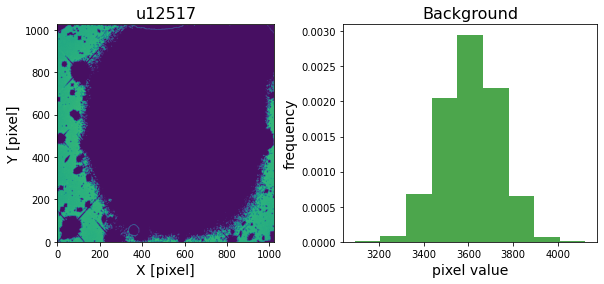

In [31]:
obj.plot_background()

N_cross: 0
r0: 3
r1: 297
nr: 10
sky: 3246
CPU times: user 474 ms, sys: 397 ms, total: 871 ms
Wall time: 639 ms


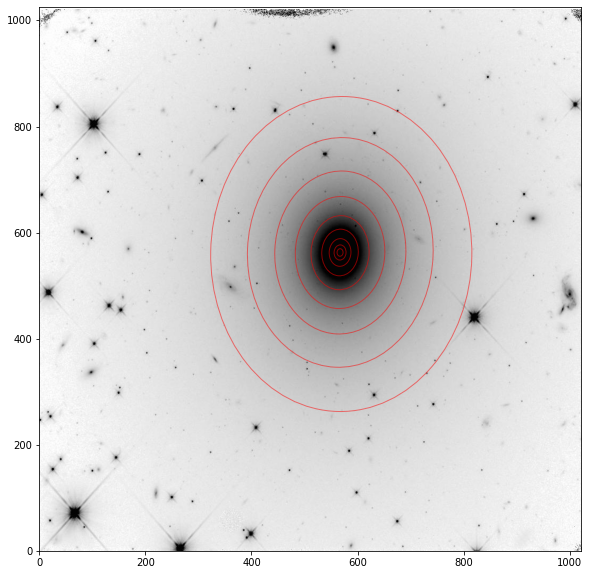

In [32]:
%%time

r0 = 3              # pixel
c_kron = 3       # Kron radius factor
k = 30 
sky_factor = 0.9    # always less than one

r1 = int(c_kron*np.sqrt(obj.a*obj.b))
nr = int(np.round(r1/k))
sky = int(sky_factor*obj.sky_med)

msg = obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="")

n_cross = Xellipses(obj.list_ellipses(model=0))
        
ax = obj.tv(options="sqrt")
ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

print("N_cross: %d"%n_cross)
print("r0: %d"%r0)
print("r1: %d"%r1)
print("nr: %d"%nr)
print("sky: %d"%sky)

N_cross: 15
r0: 3
r1: 1985
nr: 66
sky: 0
CPU times: user 2.43 s, sys: 721 ms, total: 3.15 s
Wall time: 2.18 s


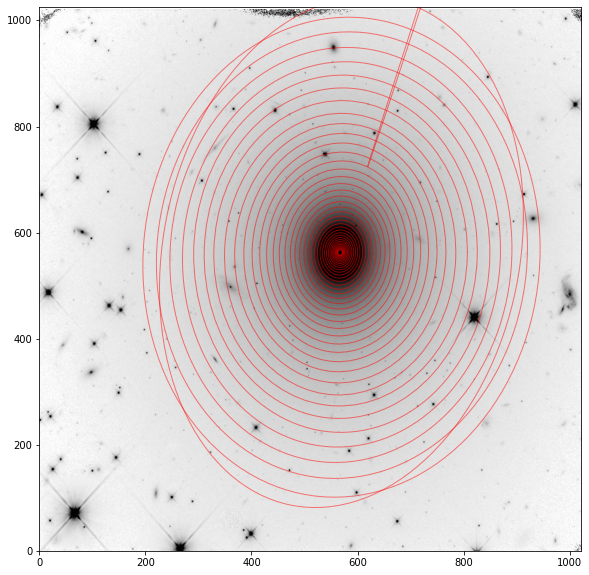

In [25]:
%%time

r0 = 3              # pixel
c_kron = 20       # Kron radius factor
k = 30 
sky_factor = 0    # always less than one

r1 = int(c_kron*np.sqrt(obj.a*obj.b))
nr = int(np.round(r1/k))
sky = int(sky_factor*obj.sky_med)

msg = obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="")

n_cross = Xellipses(obj.list_ellipses(model=0))
        
ax = obj.tv(options="sqrt")
ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')

print("N_cross: %d"%n_cross)
print("r0: %d"%r0)
print("r1: %d"%r1)
print("nr: %d"%nr)
print("sky: %d"%sky)

In [21]:
%%time

r0 = 5              # pixel
c_kron = 5.0        # Kron radius factor
k = 14 
sky_factor = 0.9    # always less than one


t_indx = 100
indlst = []

for c_kron in np.arange(2.5, 5.5, 0.5):
    for sky_factor in np.arange(0.75, 1.1, 0.05):
        for r0 in range(3,11,2):
    
            r1 = int(c_kron*np.sqrt(obj.a*obj.b))
            nr = int(np.round(r1/k))
            sky = int(sky_factor*obj.sky_med)


            # generates model 0, using common mask
            if obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="") != 'OK':
                print("Err1: ", t_indx, r0, r1, nr, k, sky_factor, c_kron)
                t_indx+=1
                continue
            
            n_cross = Xellipses(obj.list_ellipses(model=0))
            if n_cross>0:
                print("N_cross 1: ", n_cross, t_indx, r0, r1, nr, k, sky_factor, c_kron)
                t_indx+=1
                continue
                
            # usese residuals of model 0, generates mask t
            obj.objSEextract(model=0, smooth=3, minArea=20, thresh=4, mask=t_indx)
            
            ## generates model t, uses mask t      
            if obj.elliprof(r0, r1, nr=nr, mask=t_indx, model=t_indx, niter=10, sky=sky, options="")  != 'OK':
                print("Err2: ", t_indx, r0, r1, nr, k, sky_factor, c_kron)
                t_indx+=1
                continue
                
            n_cross = Xellipses(obj.list_ellipses(model=t_indx))
            if n_cross>0:
                print("N_cross 2: ", n_cross, t_indx, r0, r1, nr, k, sky_factor, c_kron)
                t_indx+=1
                continue

        #     print(t_indx)
            indlst.append(t_indx)
            t_indx+=1


Err2:  100 3 260 19 14 0.75 2.5
Err2:  104 3 260 19 14 0.8 2.5
Err2:  108 3 260 19 14 0.8500000000000001 2.5
Err2:  112 3 260 19 14 0.9000000000000001 2.5
Err2:  116 3 260 19 14 0.9500000000000002 2.5
Err2:  120 3 260 19 14 1.0000000000000002 2.5
Err2:  128 3 260 19 14 1.1000000000000003 2.5
Err2:  132 3 312 22 14 0.75 3.0
Err2:  136 3 312 22 14 0.8 3.0
Err2:  140 3 312 22 14 0.8500000000000001 3.0
N_cross 1:  4 144 3 312 22 14 0.9000000000000001 3.0
N_cross 2:  15 145 5 312 22 14 0.9000000000000001 3.0
N_cross 1:  1 146 7 312 22 14 0.9000000000000001 3.0
Err2:  148 3 312 22 14 0.9500000000000002 3.0
Err2:  152 3 312 22 14 1.0000000000000002 3.0
N_cross 1:  10 153 5 312 22 14 1.0000000000000002 3.0
N_cross 1:  1 156 3 312 22 14 1.0500000000000003 3.0
N_cross 2:  1 157 5 312 22 14 1.0500000000000003 3.0
Err2:  160 3 312 22 14 1.1000000000000003 3.0
Err1:  161 5 312 22 14 1.1000000000000003 3.0
Err2:  164 3 364 26 14 0.75 3.5
N_cross 1:  1 165 5 364 26 14 0.75 3.5
Err2:  168 3 364 26 14 

TopologyException: found non-noded intersection between LINESTRING (694.995 1174.85, 695.1 1175.16) and LINESTRING (695.205 1175.47, 695.1 1175.16) at 695.10000000000002 1175.1600000000001


((564.44, 563.38, 121.3, 103.9541, 99.61), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((564.31, 563.31, 135.2, 116.8128, 96.54), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((564.52, 562.99, 150.3, 128.6568, 94.03), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((564.85, 562.54, 166.5, 142.0245, 267.37), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((564.45, 562.48, 184.1, 154.27579999999998, 261.99), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((564.25, 561.85, 203.0, 168.48999999999998, 259.76), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((563.97, 562.33, 223.3, 188.24190000000002, 257.7), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((563.71, 562.99, 245.2, 205.23239999999998, 253.62), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((564.01, 561.35, 268.6, 224.0124, 252.63), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (529.173 684.385, 529.184 684.418) and LINESTRING (529.195 684.451, 529.184 684.418) at 529.18391542349707 684.4180400622547


((564.7, 562.31, 293.6, 243.68800000000002, 250.99), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((565.46, 563.92, 320.3, 267.7708, 249.43), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (548.521 741.613, 548.571 741.761) and LINESTRING (548.621 741.91, 548.571 741.761) at 548.57123090847938 741.76130020075368


((562.52, 564.92, 348.8, 292.992, 249.84), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((560.73, 565.49, 379.2, 318.52799999999996, 251.12), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((562.41, 566.29, 411.6, 339.98160000000007, 249.0), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((560.55, 565.29, 445.9, 371.43469999999996, 249.3), (695.1, 1175.16, 521.0, 0.0, 251.32))


TopologyException: found non-noded intersection between LINESTRING (528.233 681.605, 528.233 681.605) and LINESTRING (528.233 681.606, 528.233 681.605) at 528.23293781076495 681.60526504577388


((549.75, 562.3, 482.4, 435.1248, 245.95), (695.1, 1175.16, 521.0, 0.0, 251.32))
N_cross 1:  16 281 5 521 37 14 1.0000000000000002 5.0
N_cross 2:  1 282 7 521 37 14 1.0000000000000002 5.0
Err2:  283 9 521 37 14 1.0000000000000002 5.0
N_cross 1:  3 284 3 521 37 14 1.0500000000000003 5.0
N_cross 1:  7 285 5 521 37 14 1.0500000000000003 5.0
N_cross 1:  16 287 9 521 37 14 1.0500000000000003 5.0
Err1:  288 3 521 37 14 1.1000000000000003 5.0
Err1:  289 5 521 37 14 1.1000000000000003 5.0
Err1:  290 7 521 37 14 1.1000000000000003 5.0
Err1:  291 9 521 37 14 1.1000000000000003 5.0
CPU times: user 6min 37s, sys: 1min 51s, total: 8min 28s
Wall time: 8min 45s


In [22]:
print(indlst)

[101, 102, 103, 105, 106, 107, 109, 110, 111, 113, 114, 115, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 135, 137, 138, 139, 141, 142, 143, 147, 149, 150, 151, 154, 155, 158, 159, 162, 163, 166, 167, 169, 170, 171, 173, 174, 175, 177, 181, 183, 185, 186, 187, 189, 190, 193, 194, 195, 197, 198, 201, 202, 203, 205, 206, 207, 209, 210, 211, 213, 214, 215, 217, 218, 221, 223, 225, 230, 231, 234, 242, 243, 246, 251, 254, 257, 258, 261, 263, 265, 269, 271, 274, 277, 286]


In [23]:
len(indlst)

100

In [24]:
def maksOpen(inMask):
    
    ## Monsta script
    script = """
    rd 1 """+inMask+"""
    wd 1 """+inMask+'.fits'+""" 
    q

    """       

    run_monsta(script, 'monsta.pro', 'monsta.log')
    xcmd("rm monsta.log; rm monsta.pro", False)
    return imOpen(inMask+'.fits')

In [25]:
outFolder = 'Outputs_'+obj.name+'/'

CPU times: user 1.08 s, sys: 1.36 s, total: 2.44 s
Wall time: 6.21 s


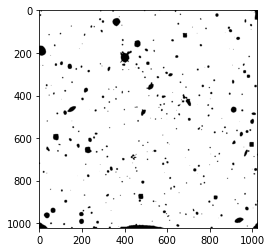

In [26]:
%%time

IM = None
for idx in indlst:
    suffix = '.%03d'%idx
    mask_name = "mask"+suffix
    
    im, header = maksOpen(outFolder+mask_name)
    im = np.abs(im-1)
    
    if IM is None:
        IM = im
    else:
        IM = IM+im

IM /= len(indlst)
IM[IM>=0.99] = 1
IM[IM<0.99] = 0

IM = np.abs(IM-1)      
plt.imshow(IM, cmap=plt.get_cmap('gray'))


In [27]:
fits.writeto(outFolder+'mask.super.fits', IM, header, overwrite=True)


sex n0679/n0679j.fits -c wfc3j.inpar -CHECKIMAGE_TYPE SEGMENTATION -CHECKIMAGE_NAME Outputs_n0679/segment.fits -CATALOG_NAME  Outputs_n0679/catal.cat -DETECT_MINAREA 10 -DETECT_THRESH 2 -WEIGHT_TYPE NONE


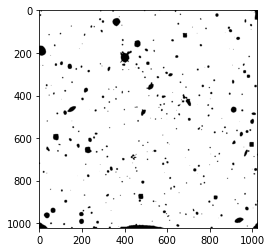

In [28]:
name = obj.name
segment = outFolder+'segment.fits'
objCatal = outFolder+'catal.cat'
objname = "{}/{}j.fits".format(name,name)
sex_cmd = """sex """+objname+""" -c wfc3j.inpar -CHECKIMAGE_TYPE SEGMENTATION -CHECKIMAGE_NAME """+segment
sex_cmd += " -CATALOG_NAME  "+objCatal
sex_cmd += " -DETECT_MINAREA 10"
sex_cmd += " -DETECT_THRESH 2"
sex_cmd += " -WEIGHT_TYPE NONE"
xcmd(sex_cmd, True)
#######################################
im, _ = imOpen(segment)
im[im<=1] = 1
im[im>1] = 0
IM_ = IM * im
plt.imshow(IM, cmap=plt.get_cmap('gray'))
fits.writeto(outFolder+'mask.super.fits', np.float32(IM_), header, overwrite=True)

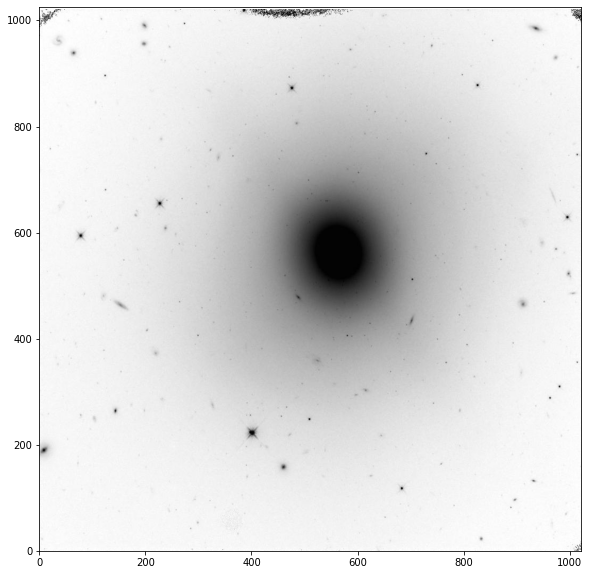

In [29]:
obj.tv(options='log')

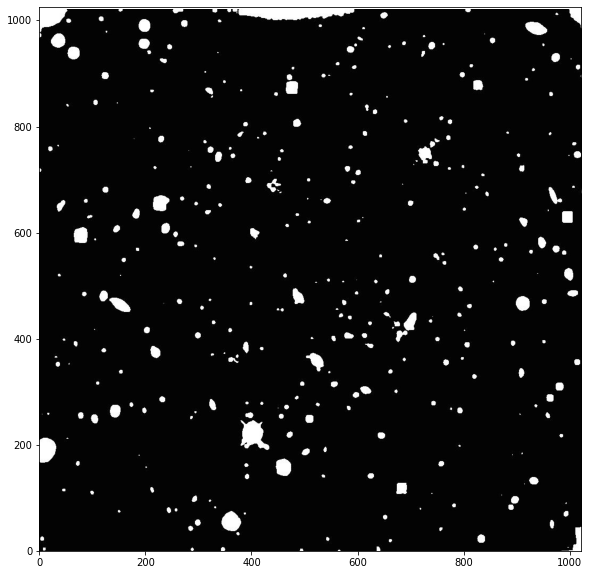

In [43]:
tv(outFolder+'mask.super.fits')

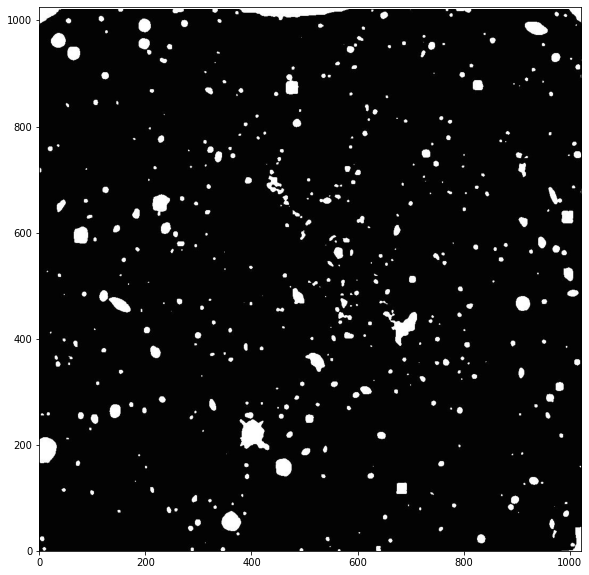

In [31]:
mask_name = "mask.140"
ax = tv('Outputs_'+obj.name+'/'+mask_name)

297 21 3246
CPU times: user 62.1 ms, sys: 29.6 ms, total: 91.7 ms
Wall time: 1.1 s


Text(0.5, 1.0, 'u12517')

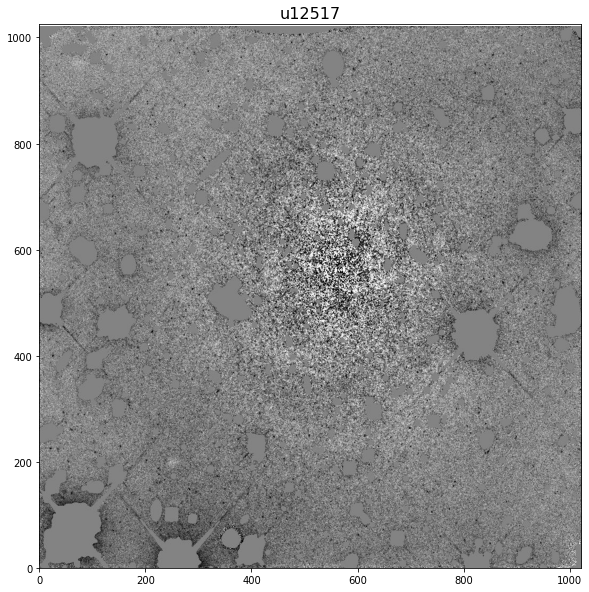

In [28]:
%%time

r0 = 3
r1 = int(3*np.sqrt(obj.a*obj.b))
nr = int(np.round(r1/14))
sky_factor = 0.9    # always less than one
sky = int(sky_factor*obj.sky_med)

print(r1, nr, sky)


# generates model 0, using common mask
obj.elliprof(r0, r1, nr=nr, sky=sky, niter=10, options="COS4X=2") 

# usese residuals of model 0, generates mask 0
obj.objSEextract(model=0, smooth=3, minArea=15, thresh=3)    

## generates model 1, uses mask 0      
obj.elliprof(r0, r1, nr=nr, mask=0, model=1, niter=10, sky=sky, options="COS4X=2")  

ax = obj.tv_resid(model=1)

# ax = obj.tv(options='sqrt cf=jt')
# Ell = make_Ellipse([obj.x0, obj.y0], obj.a, obj.b, obj.angle)
# plot_Ellipse(Ell, ax=ax, edgecolor='r', facecolor='none')

# ax = obj.plot_ellipse(model=1, ax=ax, alpha=0.5, linewidth=1, edgecolor='r', facecolor='none')



ax.set_title(obj.name, fontsize=16)

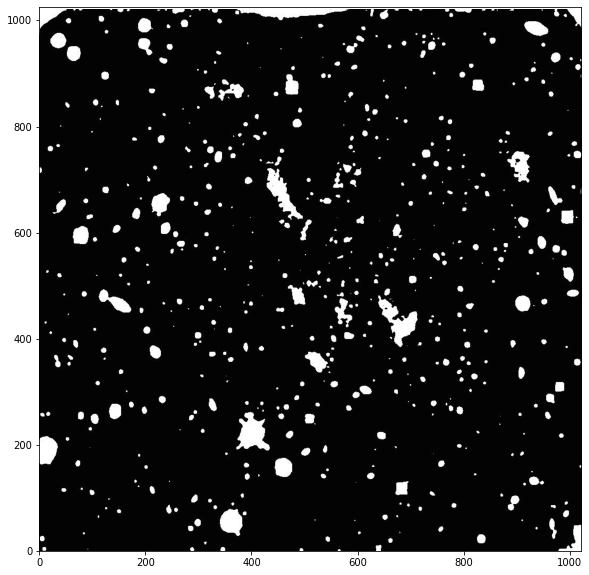

In [33]:
mask_name = "mask.000"
ax = tv('Outputs_'+obj.name+'/'+mask_name)

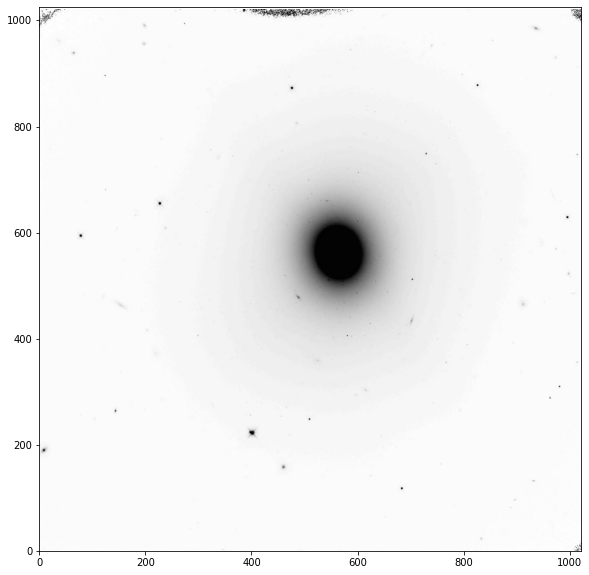

In [34]:
obj.tv(options="sqt", additions="smooth 1 fw=0")

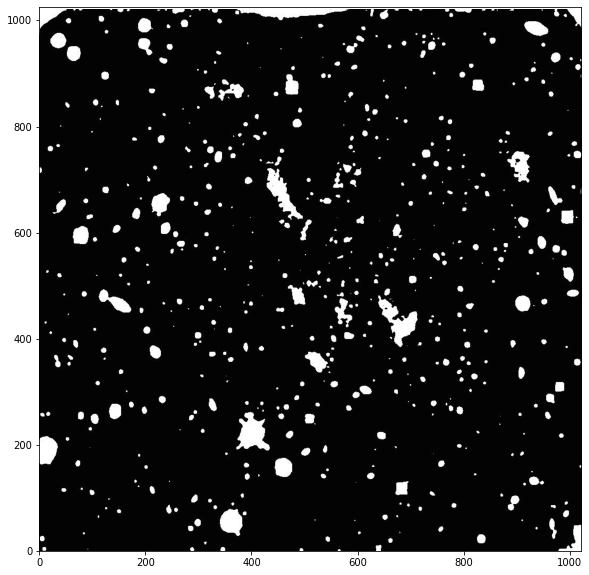

In [35]:
ax = tv('Outputs_n0679/mask.000')
# ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=2, edgecolor='r', facecolor='none')

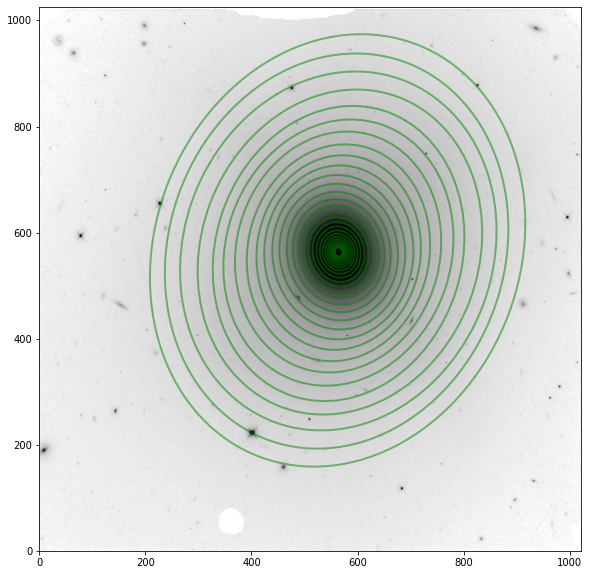

In [36]:
ax = obj.plot_object(model=0)
ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=2, edgecolor='g', facecolor='none')

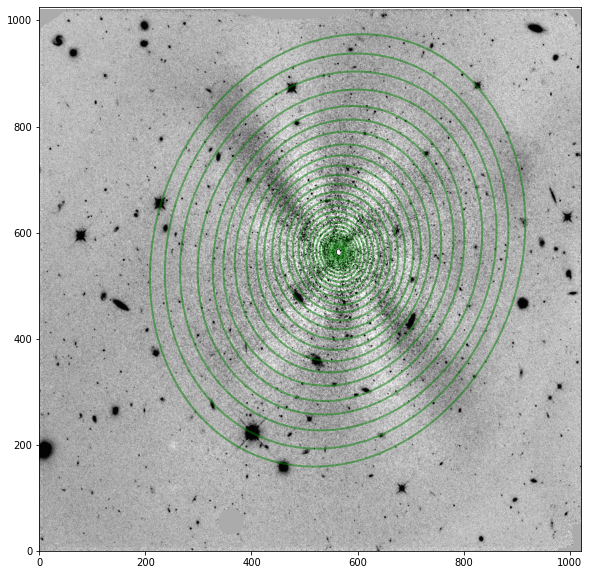

In [37]:
ax = obj.plot_resid(model=0)
ax = obj.plot_ellipse(model=0, ax=ax, alpha=0.5, linewidth=2, edgecolor='g', facecolor='none')

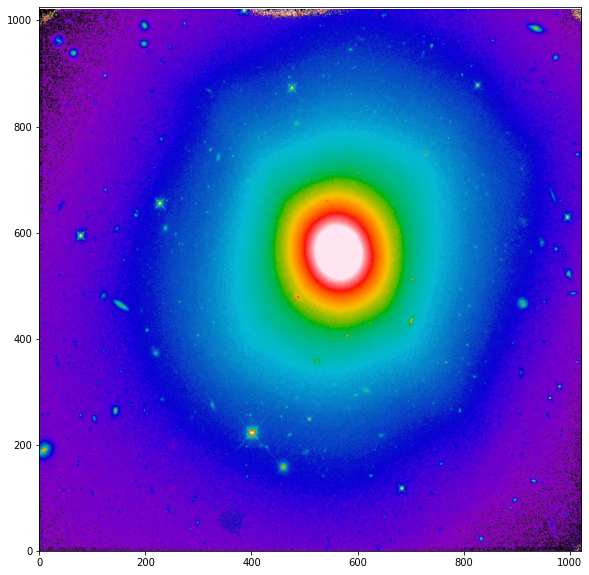

In [38]:
obj.tv(options="sqrt cf=jt")

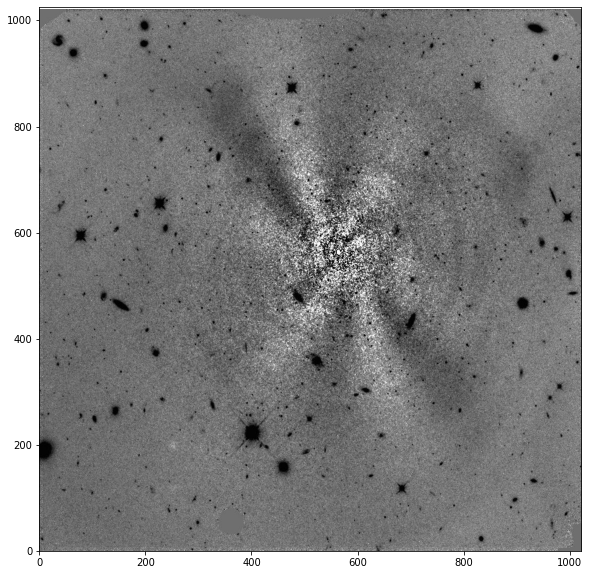

In [39]:
obj.tv_resid(model=0, options="sqrt")

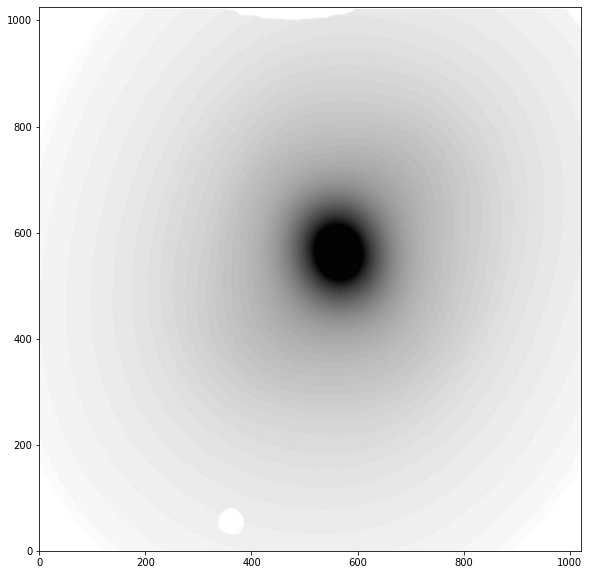

In [40]:
obj.tv_model(model=0, options="sqrt")

In [41]:
imarray.shape

NameError: name 'imarray' is not defined